## Setup

In [1]:
# pip install transformers
# pip install sentencepiece
# pip install jiwer
# pip install datasets
# pip install evaluate
# pip install -U accelerate

# pip install matplotlib
# pip install protobuf==3.20.1
# pip install tensorboard
# pip install torchvision

## Imports

In [2]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel, 
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

In [3]:
bold = f"\033[1m"
reset = f"\033[0m"

In [4]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(100)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Download and Extract the Dataset

In [6]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [7]:
URL = r"https://www.dropbox.com/scl/fi/vyvr7jbdvu8o174mbqgde/scut_data.zip?rlkey=fs8axkpxunwu6if9a2su71kxs&dl=1"
asset_zip_path = os.path.join(os.getcwd(), "scut_data.zip")
# Download if asset ZIP does not exist.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

## Training and Dataset Configurations

In [8]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 48
    EPOCHS:        int = 1    # change the epochs to 20 for official training
    # EPOCHS:        int = 20    
    LEARNING_RATE: float = 0.0005  # the original setting for the small model is 0.00005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'scut_data'

@dataclass(frozen=True)
class ModelConfig:
    # MODEL_NAME: str = 'microsoft/trocr-small-printed'
    MODEL_NAME: str = 'microsoft/trocr-large-printed'

## The SCUT Dataset

The SCUT dataset that we are using contains a total of 7703 images. Out of these 6052 are training samples and 1651 are validation samples. Here is the directory structure of the `scut_data` directory after downloading and extracting it.

```
scut_data/
├── scut_train
├── scut_test
├── scut_train.txt
└── scut_test.txt
```

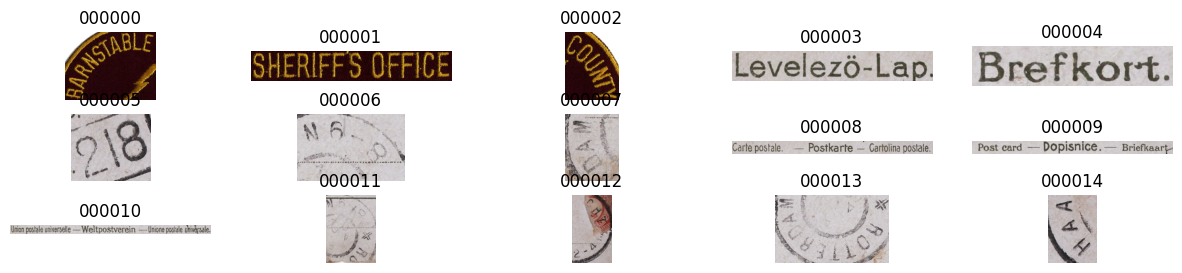

In [9]:
def visualize(dataset_path):
    plt.figure(figsize=(15, 3))
    for i in range(15):
        plt.subplot(3, 5, i+1)
        all_images = os.listdir(f"{dataset_path}/scut_train")
        image = plt.imread(f"{dataset_path}/scut_train/{all_images[i]}")
        plt.imshow(image)
        plt.axis('off')
        plt.title(all_images[i].split('.')[0])
    plt.show()

visualize(DatasetConfig.DATA_ROOT)

## Prepare Dataset

In [10]:
train_df = pd.read_fwf(
    os.path.join(DatasetConfig.DATA_ROOT, 'scut_train.txt'), header=None
)
train_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)
test_df = pd.read_fwf(
    os.path.join(DatasetConfig.DATA_ROOT, 'scut_test.txt'), header=None
)
test_df.rename(columns={0: 'file_name', 1: 'text'}, inplace=True)

In [11]:
train_df.head()

,file_name,text
0,000000.jpg,BARNSTABLE
1,000001.jpg,SHERIFF'S OFFICE
2,000002.jpg,COUNTY
3,000003.jpg,Levelezo-Lap.
4,000004.jpg,Brefkort


In [12]:
test_df.head()

,file_name,text
0,006052.jpg,ty Starts with Education
1,006053.jpg,Cardi's
2,006054.jpg,YOU THE BUSINESS SIDE OF GREEN
3,006055.jpg,hat is
4,006056.jpg,all of us


In [13]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    #gaussian_blur will blur the images with a random kernel size and sigma.
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

In [14]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['file_name'][idx]
        # The text (label).
        text = self.df['text'][idx]
        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [15]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'scut_train/'),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'scut_test/'),
    df=test_df,
    processor=processor
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [16]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 6052
Number of validation examples: 1651


In [17]:
encoding = train_dataset[0]
for k,v in encoding.items():
    print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


(-0.5, 797.5, 598.5, -0.5)

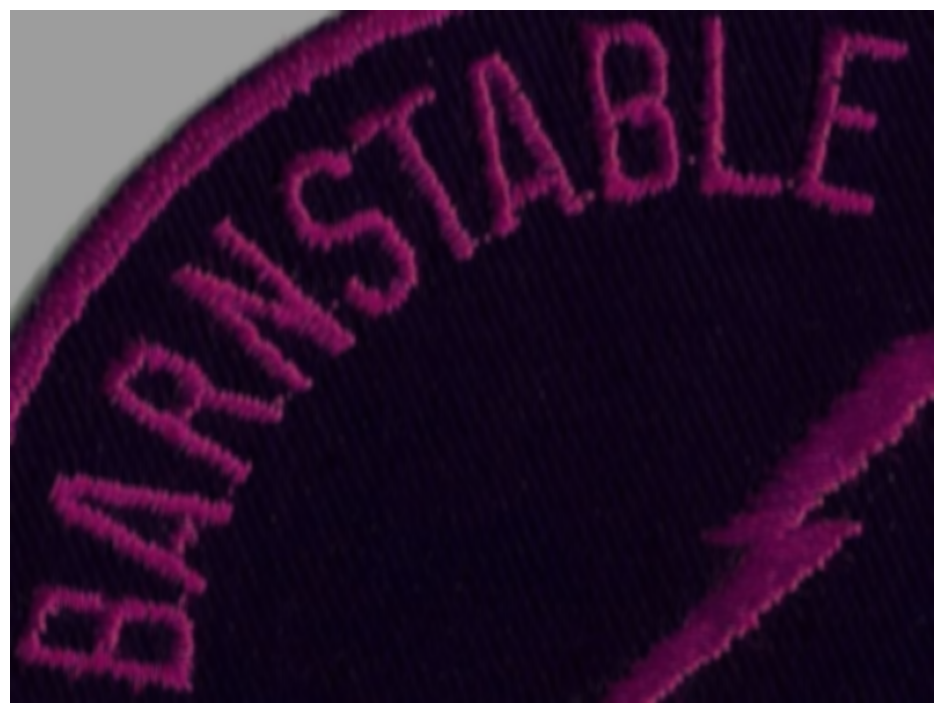

In [18]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image = train_transforms(image)
plt.imshow(image)
plt.axis('off')

In [19]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

BARNSTABLE


## Initialize the Model

In [20]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=False)
              (key): Linear(in_features=1024, out_features=1024, bias=False)
              (value): Linear(in_features=1024, out_features=1024, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Line

## Model Configurations

In [21]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id

model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

We use the AdamW optimizer here with a weight decay of 0.0005.

In [22]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

## Evaluation Metric

In [23]:
# accuracy matrics
def accuracy_by_letter_v2(pred, actual):
    max_length = max(len(pred), len(actual))
    min_length = min(len(pred), len(actual))
    letters_correct = 0
    for i in range(min_length):
        if pred[i] == actual[i]:
            letters_correct += 1
    return letters_correct / max_length


def calculate_accuracies_v2(labels, predictions)->tuple:
    acc_letter = []
    acc_word = 0

    for i in range(len(predictions)):
        acc_letter_i =(accuracy_by_letter_v2(predictions[i], labels[i]))
        acc_letter.append(acc_letter_i)
        if acc_letter_i == 1:
            acc_word += 1
    return (np.mean(acc_letter),  acc_word/len(labels))

In [24]:
cer_metric = evaluate.load('cer')

In [25]:
def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    # add accuracy metrics
    acc_letter, acc_word = calculate_accuracies_v2(label_str, pred_str)

    return {"cer": cer, "Accuracy by Letter": acc_letter, "Accuracy by Word": acc_word}

    # return {"cer": cer}

## Training and Validation Loops

In [26]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    # set fp16 to True to enable mixed precision training when using GPUs
    
    ########################################
    # if using CPU, set fp16_training to False
    fp16=False,

    # if using GPU, set fp16_training to True
    # fp16=True, 
    ########################################

    output_dir='seq2seq_model_printed/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

In [27]:
# Initialize trainer.
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

c:\Users\lisaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\trocr\processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


## Train

In [28]:
res = trainer.train()

  0%|          | 0/127 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
res

## Inference

In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(res.global_step)).to(device)

In [ ]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.

    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [ ]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.

    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [ ]:
def eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'scut_test', '*'),
    num_samples=50
):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_and_show(image_path)
        text = ocr(image, processor, trained_model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()

In [ ]:
eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'scut_test', '*'),
    num_samples=100
)